# Data Intensive Computing Project - Phase II

### Pradeepsurya Rajendran (rajendr4)

## Load Data

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.3 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump

import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings("ignore")

SEED = 587

In [2]:
df = pd.read_csv('preprocessed_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 56 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   Month                                               100000 non-null  float64
 1   Age                                                 100000 non-null  float64
 2   Annual_Income                                       100000 non-null  float64
 3   Monthly_Inhand_Salary                               100000 non-null  float64
 4   Num_Bank_Accounts                                   100000 non-null  float64
 5   Num_Credit_Card                                     100000 non-null  float64
 6   Interest_Rate                                       100000 non-null  float64
 7   Num_of_Loan                                         100000 non-null  float64
 8   Delay_from_due_date                                 100000 non-nu

In [3]:
y = df['Credit_Score']
X = df.drop(['Credit_Score'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=SEED)

## 1. Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Simple interpretable Decision Tree
decision_tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5000, min_samples_split=5000, random_state=SEED)
decision_tree.fit(X_train, y_train) 

y_pred_decision_tree = decision_tree.predict(X_test)

print(classification_report(y_test, y_pred_decision_tree))

conf_matrix = confusion_matrix(y_test, y_pred_decision_tree, labels=['Good', 'Poor', 'Standard'])
print(conf_matrix)

              precision    recall  f1-score   support

        Good       0.51      0.76      0.61      3566
        Poor       0.69      0.54      0.61      5799
    Standard       0.71      0.68      0.70     10635

    accuracy                           0.65     20000
   macro avg       0.64      0.66      0.64     20000
weighted avg       0.67      0.65      0.65     20000

[[2707   40  819]
 [ 573 3144 2082]
 [2056 1356 7223]]


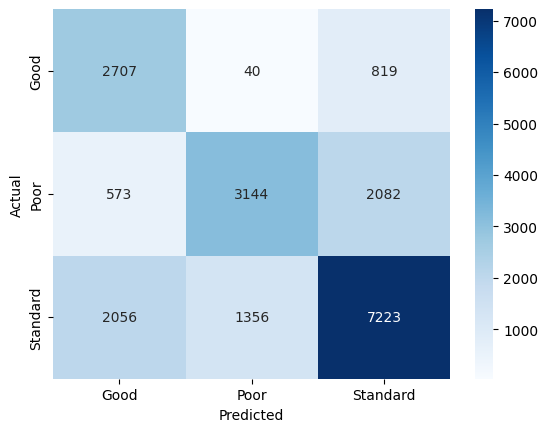

In [ ]:
# Confusion matrix heatmap using Seaborn
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [ ]:
# Input data without feature scaling - for ease of interpreting Decision Tree
data = pd.read_csv('preprocessed_no_scale.csv')

yd = data['Credit_Score']
Xd = data.drop(['Credit_Score'], axis=1)

Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.2, stratify=yd, random_state=SEED)

from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5000, min_samples_split=5000, random_state=SEED)
decision_tree.fit(Xd_train, yd_train) 

DecisionTreeClassifier(max_depth=4, min_samples_leaf=5000,
                       min_samples_split=5000, random_state=587)

In [ ]:
yd_pred_decision_tree = decision_tree.predict(Xd_test)
print(classification_report(yd_test, yd_pred_decision_tree))

              precision    recall  f1-score   support

        Good       0.51      0.76      0.61      3566
        Poor       0.69      0.54      0.61      5799
    Standard       0.71      0.68      0.70     10635

    accuracy                           0.65     20000
   macro avg       0.64      0.66      0.64     20000
weighted avg       0.67      0.65      0.65     20000



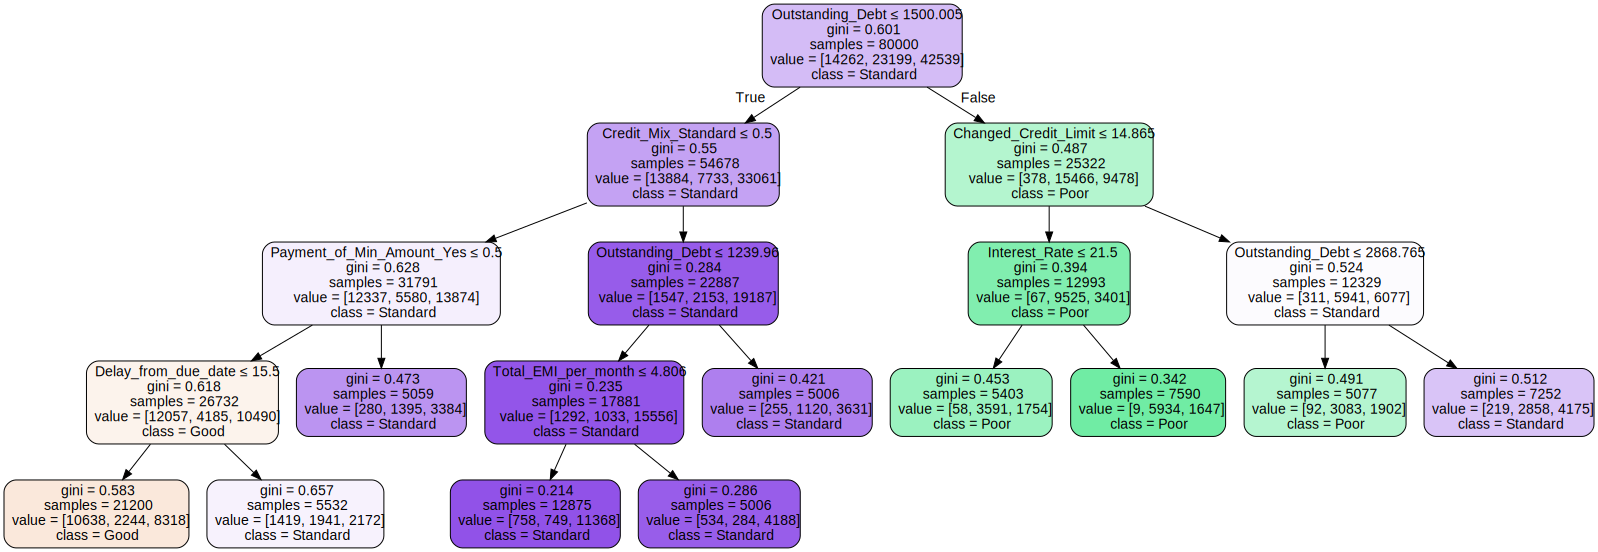

In [ ]:
from IPython.display import SVG
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(decision_tree, 
                                feature_names=Xd.columns,  
                                class_names=['Good', 'Poor', 'Standard'],
                                filled=True,
                                rounded=True,  
                                special_characters=True,
                                out_file=None)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [ ]:
graph.render("simple_dt")

'simple_dt.png'

### Hyperparameter Tuning using Optuna

In [ ]:
# Define the objective functions for Optuna
def decision_tree_objective(trial):
    dt = DecisionTreeClassifier(criterion = trial.suggest_categorical("criterion", ["gini", "entropy"]),
                                max_depth=trial.suggest_int('max_depth', 2, 20), 
                                min_samples_split=trial.suggest_int('min_samples_split', 2, 20), 
                                min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20))

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(dt, X_train, y_train, cv=cv, scoring=make_scorer(f1_score, average='weighted'))
    return np.mean(score)

study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(decision_tree_objective, n_trials=400, show_progress_bar=True)

[I 2023-04-09 16:43:21,842] A new study created in memory with name: no-name-7a64270c-b9f0-4f7a-8711-ce822fe94e5d
/usr/local/lib/python3.9/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/400 [00:00<?, ?it/s]

[I 2023-04-09 16:43:25,949] Trial 0 finished with value: 0.6490332310502227 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.6490332310502227.
[I 2023-04-09 16:43:29,517] Trial 1 finished with value: 0.6490332310502227 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6490332310502227.
[I 2023-04-09 16:43:38,035] Trial 2 finished with value: 0.7045351226718781 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 19}. Best is trial 2 with value: 0.7045351226718781.
[I 2023-04-09 16:43:46,908] Trial 3 finished with value: 0.705380266562029 and parameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 12}. Best is trial 3 with value: 0.705380266562029.
[I 2023-04-09 16:43:54,308] Trial 4 finished with value: 0.7044452263289929 and p

In [ ]:
#best hyperparameters and F1score
print('Best F1 Score = {:.2f}, Best hyperparameters = {}'.format(study_dt.best_value, study_dt.best_params))

Best F1 Score = 0.71, Best hyperparameters = {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 13}


In [ ]:
# Plot the optimization history and importance of each hyperparameter
optuna.visualization.plot_optimization_history(study_dt).show()
optuna.visualization.plot_param_importances(study_dt).show()

### Training with optimal hyperparameters and predict

In [19]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(**{'criterion': 'gini', 'max_depth': 20, 
                                          'min_samples_split': 11, 'min_samples_leaf': 13, 
                                          'random_state': SEED})
decision_tree.fit(X_train, y_train)

y_pred_decision_tree = decision_tree.predict(X_test)
y_pred_dt_train = decision_tree.predict(X_train)

print("\n=== Training Result ===\n")
print(classification_report(y_train, y_pred_dt_train))

print("\n=== Test Result ===\n")
print(classification_report(y_test, y_pred_decision_tree))
conf_matrix = confusion_matrix(y_test, y_pred_decision_tree, labels=['Good', 'Poor', 'Standard'])
print(conf_matrix)


=== Training Result ===

              precision    recall  f1-score   support

        Good       0.68      0.75      0.71     14262
        Poor       0.80      0.79      0.80     23199
    Standard       0.83      0.81      0.82     42539

    accuracy                           0.79     80000
   macro avg       0.77      0.78      0.78     80000
weighted avg       0.80      0.79      0.79     80000


=== Test Result ===

              precision    recall  f1-score   support

        Good       0.62      0.69      0.65      3566
        Poor       0.72      0.70      0.71      5799
    Standard       0.76      0.75      0.75     10635

    accuracy                           0.72     20000
   macro avg       0.70      0.71      0.70     20000
weighted avg       0.72      0.72      0.72     20000

[[2458  110  998]
 [ 281 4038 1480]
 [1238 1471 7926]]


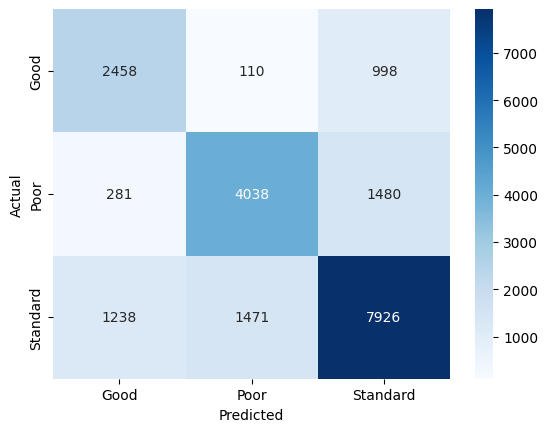

In [20]:
# Confusion matrix heatmap using Seaborn
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [ ]:
dump(decision_tree, 'decision_tree.joblib') 

['decision_tree.joblib']

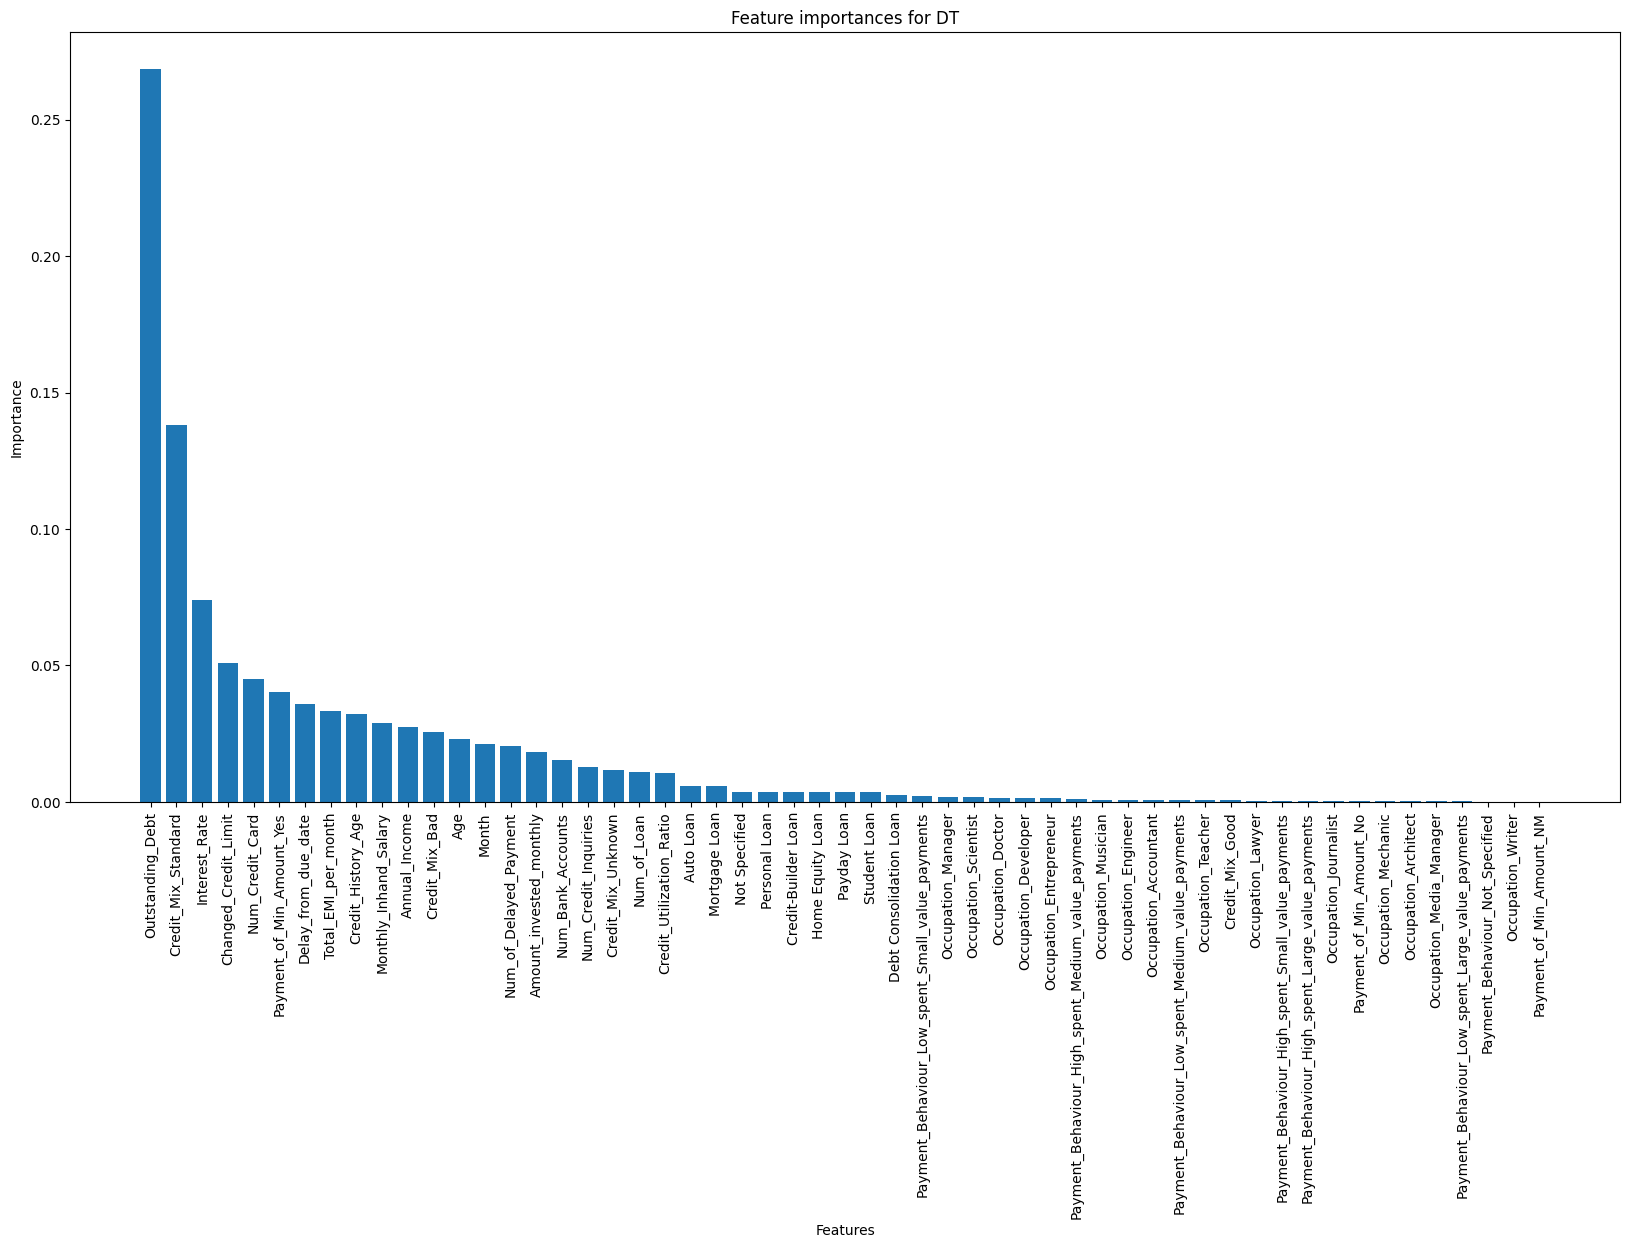

In [ ]:
importances_dt = decision_tree.feature_importances_

def plot_feature_importances(importances, feature_names, model_name):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(20,10))
    plt.title(f'Feature importances for {model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

plot_feature_importances(importances_dt, X_train.columns, 'DT')

## 2. Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

y_pred_logistic_regression = logistic_regression.predict(X_test)
y_pred_lr_train = logistic_regression.predict(X_train)

print("\n=== Training Result ===\n")
print(classification_report(y_train, y_pred_lr_train))

print("\n=== Test Result ===\n")
print(classification_report(y_test, y_pred_logistic_regression))

conf_matrix = confusion_matrix(y_test, y_pred_logistic_regression)
print(conf_matrix)


=== Training Result ===

              precision    recall  f1-score   support

           0       0.66      0.52      0.58     23199
           1       0.67      0.74      0.70     42539
           2       0.55      0.57      0.56     14262

    accuracy                           0.65     80000
   macro avg       0.63      0.61      0.62     80000
weighted avg       0.65      0.65      0.64     80000


=== Test Result ===

              precision    recall  f1-score   support

           0       0.65      0.53      0.58      5799
           1       0.68      0.74      0.71     10635
           2       0.56      0.59      0.57      3566

    accuracy                           0.65     20000
   macro avg       0.63      0.62      0.62     20000
weighted avg       0.65      0.65      0.65     20000

[[3047 2341  411]
 [1542 7827 1266]
 [  95 1369 2102]]


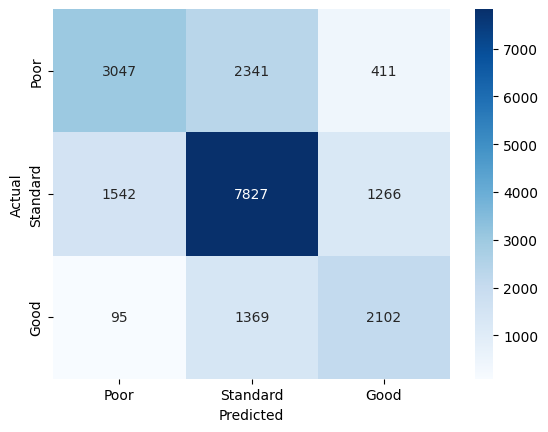

In [41]:
# Confusion matrix heatmap using Seaborn
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Poor', 'Standard', 'Good'], yticklabels=['Poor', 'Standard', 'Good'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

### Hyperparameter Tuning using Optuna





In [ ]:
# Define the objective functions for Optuna
def logistic_regression_objective(trial):

    C = trial.suggest_float("C", 1e-6, 1e+6, log=True)
    solver_penalty_pairs = [
        ("newton-cg", "l2"),("newton-cg", "none"),("lbfgs", "l2"),("lbfgs", "none"),
        ("liblinear", "l1"),("liblinear", "l2"),("sag", "l2"),("sag", "none"),("saga", "l1"),
        ("saga", "l2"),("saga", "elasticnet"),("saga", "none")
    ]
    solver, penalty = trial.suggest_categorical("solver_penalty_pairs", solver_penalty_pairs)
    max_iter = trial.suggest_int("max_iter", 100, 1000)

    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0, 1)
    else:
        l1_ratio = None

    lr = LogisticRegression(C=C, penalty=penalty, l1_ratio=l1_ratio, solver=solver, max_iter=max_iter)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(lr, X_train, y_train, cv=cv, scoring=make_scorer(f1_score, average='weighted'))
    return np.mean(score)

study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(logistic_regression_objective, n_trials=200, show_progress_bar=True)

[I 2023-04-09 18:21:13,804] A new study created in memory with name: no-name-c40bec4b-8001-4be9-9f66-637b37640ea4


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-04-09 18:21:38,265] Trial 0 finished with value: 0.642126400279462 and parameters: {'C': 2.542269672628098e-06, 'solver_penalty_pairs': ('lbfgs', 'none'), 'max_iter': 260}. Best is trial 0 with value: 0.642126400279462.
[I 2023-04-09 18:22:18,776] Trial 1 finished with value: 0.6421120640080156 and parameters: {'C': 79910.42426048213, 'solver_penalty_pairs': ('newton-cg', 'none'), 'max_iter': 694}. Best is trial 0 with value: 0.642126400279462.
[I 2023-04-09 18:23:27,103] Trial 2 finished with value: 0.6421718327170328 and parameters: {'C': 0.5396989764128136, 'solver_penalty_pairs': ('newton-cg', 'l2'), 'max_iter': 738}. Best is trial 2 with value: 0.6421718327170328.
[I 2023-04-09 18:23:57,053] Trial 3 finished with value: 0.6318071336969893 and parameters: {'C': 0.005292706182855807, 'solver_penalty_pairs': ('newton-cg', 'l2'), 'max_iter': 206}. Best is trial 2 with value: 0.6421718327170328.
[I 2023-04-09 18:24:13,504] Trial 4 finished with value: 0.6420981293736089 and par

In [ ]:
#best hyperparameters and F1score
print('Best F1 Score = {:.2f}, Best hyperparameters = {}'.format(study_lr.best_value, study_lr.best_params))

Best F1 Score = 0.64, Best hyperparameters = {'C': 0.0035477959361363024, 'solver_penalty_pairs': ('sag', 'none'), 'max_iter': 896}


In [ ]:
# Plot the optimization history and importance of each hyperparameter
optuna.visualization.plot_optimization_history(study_lr).show()
optuna.visualization.plot_param_importances(study_lr).show()

### Training and Predicting with optimal hyperparameters

In [17]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(C=0.0035477959361363024,
                                         solver='sag',
                                         penalty=None,
                                         max_iter=896,
                                         random_state=SEED)
logistic_regression.fit(X_train, y_train)

y_pred_logistic_regression = logistic_regression.predict(X_test)
y_pred_lr_train = logistic_regression.predict(X_train)

print("\n=== Training Result ===\n")
print(classification_report(y_train, y_pred_lr_train))

print("\n=== Test Result ===\n")
print(classification_report(y_test, y_pred_logistic_regression))

conf_matrix = confusion_matrix(y_test, y_pred_logistic_regression)
print(conf_matrix)


=== Training Result ===

              precision    recall  f1-score   support

        Good       0.55      0.57      0.56     14262
        Poor       0.66      0.52      0.58     23199
    Standard       0.67      0.74      0.70     42539

    accuracy                           0.65     80000
   macro avg       0.63      0.61      0.62     80000
weighted avg       0.65      0.65      0.64     80000


=== Test Result ===

              precision    recall  f1-score   support

        Good       0.56      0.59      0.57      3566
        Poor       0.65      0.53      0.58      5799
    Standard       0.68      0.74      0.71     10635

    accuracy                           0.65     20000
   macro avg       0.63      0.62      0.62     20000
weighted avg       0.65      0.65      0.65     20000

[[2102   96 1368]
 [ 410 3051 2338]
 [1260 1540 7835]]


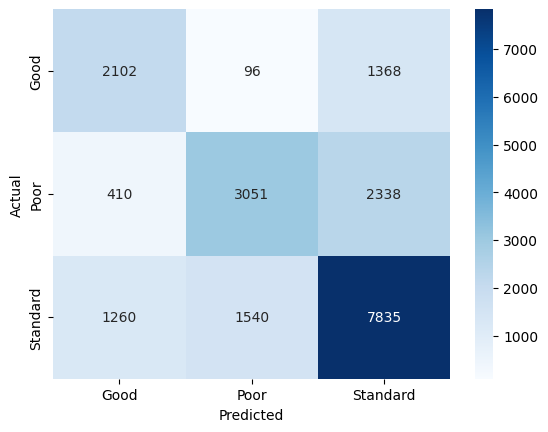

In [18]:
# Confusion matrix heatmap using Seaborn
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [ ]:
dump(logistic_regression, 'logistic_regression.joblib')

['logistic_regression.joblib']

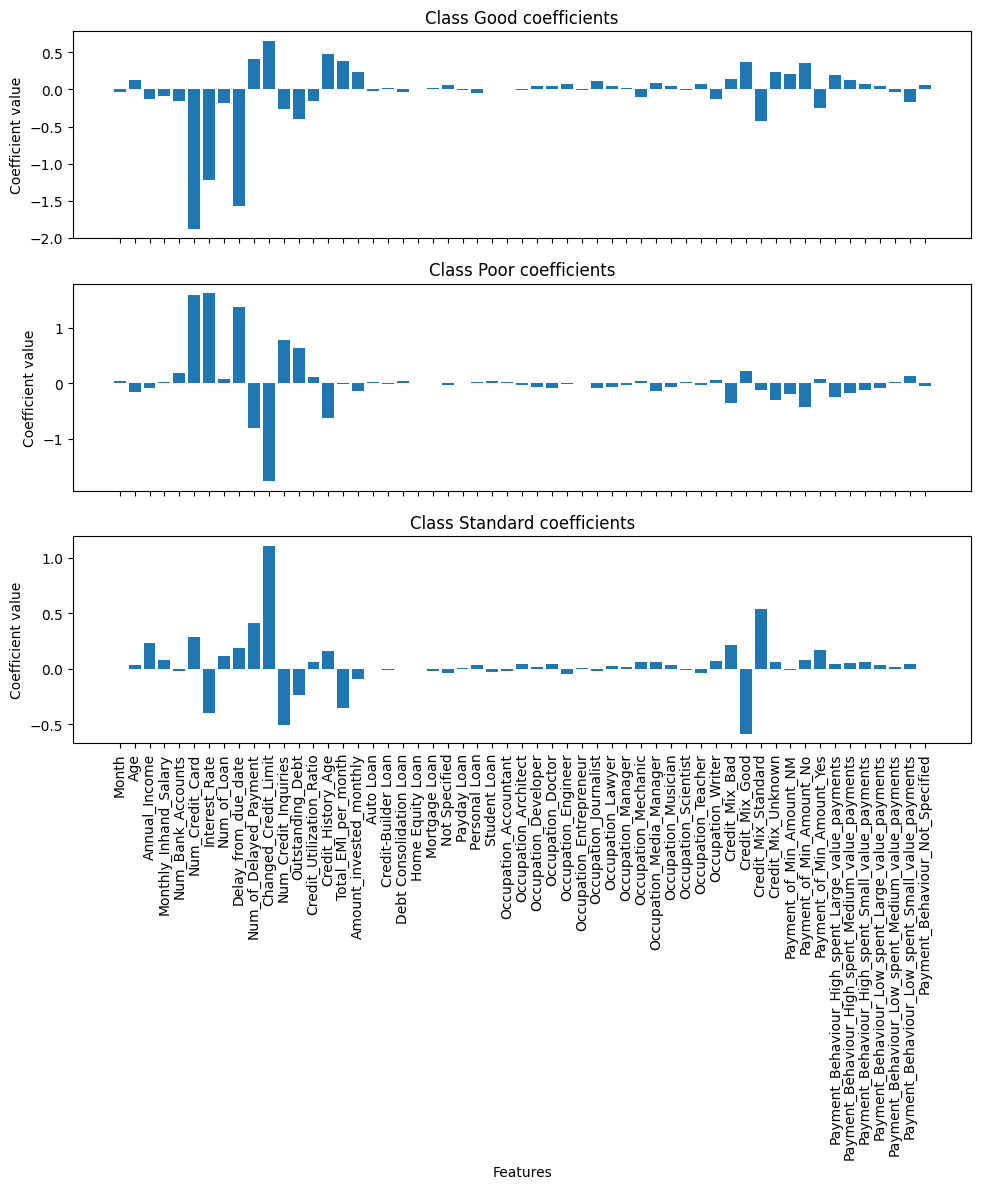

In [ ]:
feature_names = X_train.columns
class_names = logistic_regression.classes_

# model coefficients
coefficients = logistic_regression.coef_

# plot coefficients
num_classes = coefficients.shape[0]
num_features = X.shape[1]

fig, axes = plt.subplots(num_classes, 1, figsize=(10, num_classes * 4), sharex=True)
for i, coef in enumerate(coefficients):
    axes[i].bar(range(num_features), coef, align='center')
    axes[i].set_title(f'Class {class_names[i]} coefficients')
    axes[i].set_ylabel('Coefficient value')
    axes[i].set_xticks(range(num_features))
    axes[i].set_xticklabels(feature_names, rotation='vertical')

plt.xlabel('Features')
plt.tight_layout()
plt.show()

## 3. Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

y_pred_random_forest = random_forest.predict(X_test)
y_pred_rf_train = random_forest.predict(X_train)

print("\n=== Training Result ===\n")
print(classification_report(y_train, y_pred_rf_train))

print("\n=== Test Result ===\n")
print(classification_report(y_test, y_pred_random_forest))

conf_matrix = confusion_matrix(y_test, y_pred_random_forest)
print(conf_matrix)


=== Training Result ===

              precision    recall  f1-score   support

        Good       1.00      1.00      1.00     14262
        Poor       1.00      1.00      1.00     23199
    Standard       1.00      1.00      1.00     42539

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000


=== Test Result ===

              precision    recall  f1-score   support

        Good       0.76      0.74      0.75      3566
        Poor       0.79      0.82      0.80      5799
    Standard       0.82      0.81      0.82     10635

    accuracy                           0.80     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.80      0.80      0.80     20000

[[2649   14  903]
 [  69 4739  991]
 [ 755 1247 8633]]


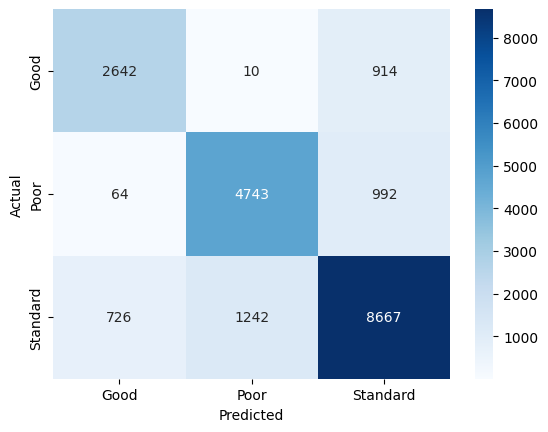

In [ ]:
# Confusion matrix heatmap using Seaborn
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

### Hyperparameter Tuning using Optuna


In [ ]:
# Define the objective functions for Optuna
def random_forest_objective(trial):
    rf = RandomForestClassifier(n_estimators = trial.suggest_int("n_estimators", 100, 200),
                                max_depth = trial.suggest_int("max_depth", 2, 20),
                                min_samples_split = trial.suggest_int("min_samples_split", 2, 20),
                                min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20))

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(rf, X_train, y_train, cv=cv, scoring=make_scorer(f1_score, average='weighted'))
    return np.mean(score)

sampler = TPESampler(seed=SEED)
study_rf = optuna.create_study(direction='maximize', sampler=sampler)
study_rf.optimize(random_forest_objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-04-09 20:32:26,180] A new study created in memory with name: no-name-9a6d2fb2-2d24-42a5-aee5-1e28e690312c


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-04-09 20:33:35,907] Trial 1 finished with value: 0.5235663312141464 and parameters: {'n_estimators': 164, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.5235663312141464.
[I 2023-04-09 20:33:38,019] Trial 2 finished with value: 0.7375371114493571 and parameters: {'n_estimators': 225, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7454402021159802.
[I 2023-04-09 20:33:55,041] Trial 0 finished with value: 0.5938283229139347 and parameters: {'n_estimators': 173, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.5938283229139347.
[I 2023-04-09 20:34:57,732] Trial 2 finished with value: 0.6585668026836214 and parameters: {'n_estimators': 151, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.6585668026836214.
[I 2023-04-09 20:38:25,843] Trial 3 finished with value: 0.7520034

In [ ]:
#best hyperparameters and F1score
print('Best F1 Score = {:.2f}, Best hyperparameters = {}'.format(study_rf.best_value, study_rf.best_params))

Best F1 Score = 0.78, Best hyperparameters = {'n_estimators': 185, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1}


In [ ]:
# Plot the optimization history and importance of each hyperparameter
optuna.visualization.plot_optimization_history(study_rf).show()
optuna.visualization.plot_param_importances(study_rf).show()

### Training and Predicting with optimal hyperparameters

In [15]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(**{'n_estimators': 185, 'max_depth': 18, 
                                          'min_samples_split': 4, 'min_samples_leaf': 1, 
                                          'random_state': SEED})
random_forest.fit(X_train, y_train)

y_pred_random_forest = random_forest.predict(X_test)
y_pred_rf_train = random_forest.predict(X_train)

print("\n=== Training Result ===\n")
print(classification_report(y_train, y_pred_rf_train))

print("\n=== Test Result ===\n")
print(classification_report(y_test, y_pred_random_forest))

conf_matrix = confusion_matrix(y_test, y_pred_random_forest)
print(conf_matrix)


=== Training Result ===

              precision    recall  f1-score   support

        Good       0.85      0.86      0.85     14262
        Poor       0.88      0.87      0.87     23199
    Standard       0.90      0.90      0.90     42539

    accuracy                           0.88     80000
   macro avg       0.88      0.88      0.88     80000
weighted avg       0.88      0.88      0.88     80000


=== Test Result ===

              precision    recall  f1-score   support

        Good       0.69      0.75      0.71      3566
        Poor       0.78      0.77      0.78      5799
    Standard       0.81      0.80      0.80     10635

    accuracy                           0.78     20000
   macro avg       0.76      0.77      0.77     20000
weighted avg       0.78      0.78      0.78     20000

[[2659   23  884]
 [ 243 4473 1083]
 [ 972 1205 8458]]


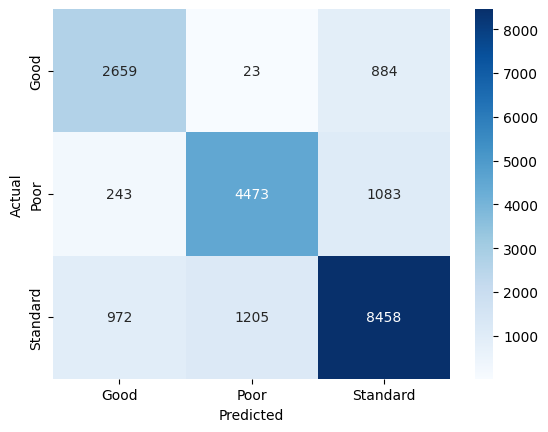

In [16]:
# Confusion matrix heatmap using Seaborn
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [ ]:
dump(random_forest, 'random_forest.joblib') 

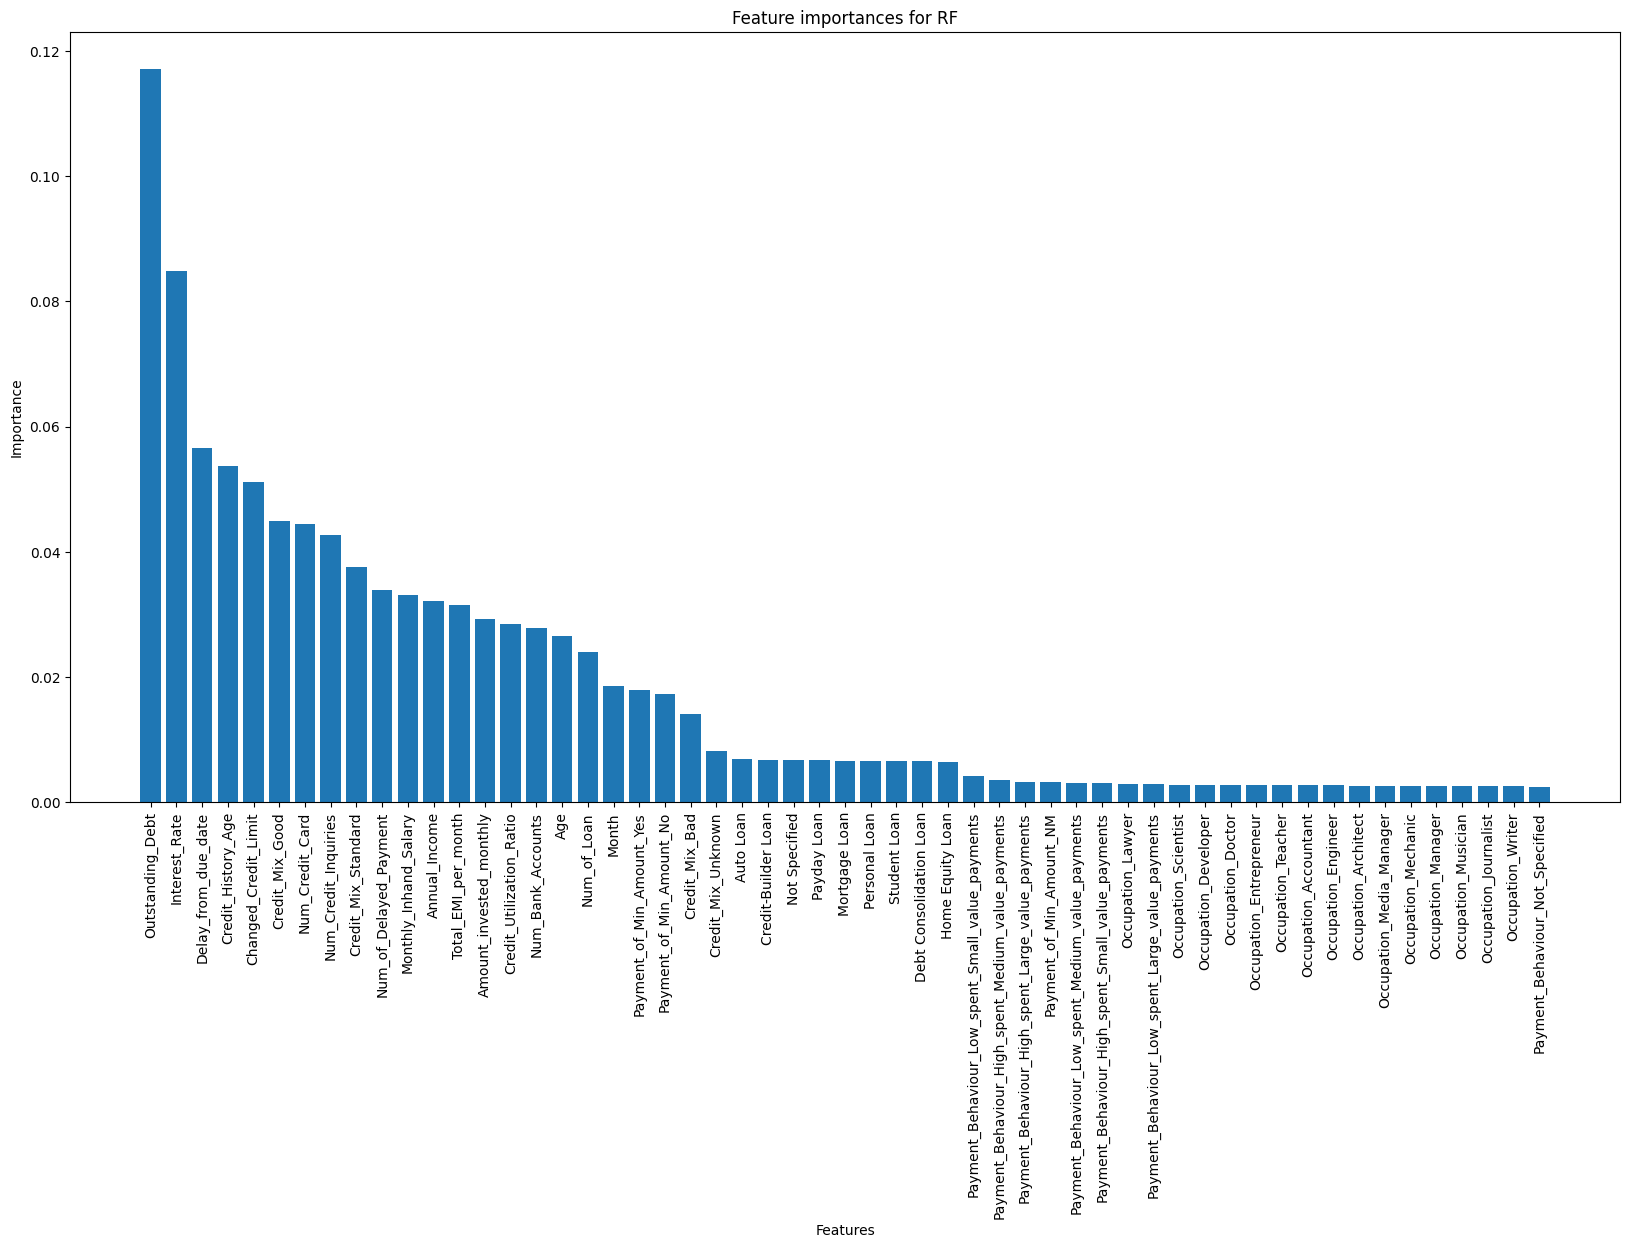

In [ ]:
importances_rf = random_forest.feature_importances_

def plot_feature_importances(importances, feature_names, model_name):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(20,10))
    plt.title(f'Feature importances for {model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

plot_feature_importances(importances_rf, X_train.columns, 'RF')

## 4. KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
y_pred_knn_train = knn.predict(X_train)

print("\n=== Training Result ===\n")
print(classification_report(y_train, y_pred_knn_train))

print("\n=== Test Result ===\n")
print(classification_report(y_test, y_pred_knn))

conf_matrix = confusion_matrix(y_test, y_pred_knn)
print(conf_matrix)


=== Training Result ===

              precision    recall  f1-score   support

        Good       0.69      0.75      0.72     14262
        Poor       0.81      0.78      0.79     23199
    Standard       0.84      0.82      0.83     42539

    accuracy                           0.80     80000
   macro avg       0.78      0.79      0.78     80000
weighted avg       0.80      0.80      0.80     80000


=== Test Result ===

              precision    recall  f1-score   support

        Good       0.55      0.61      0.58      3566
        Poor       0.72      0.67      0.70      5799
    Standard       0.75      0.75      0.75     10635

    accuracy                           0.70     20000
   macro avg       0.68      0.68      0.68     20000
weighted avg       0.71      0.70      0.71     20000

[[2179  147 1240]
 [ 458 3913 1428]
 [1298 1345 7992]]


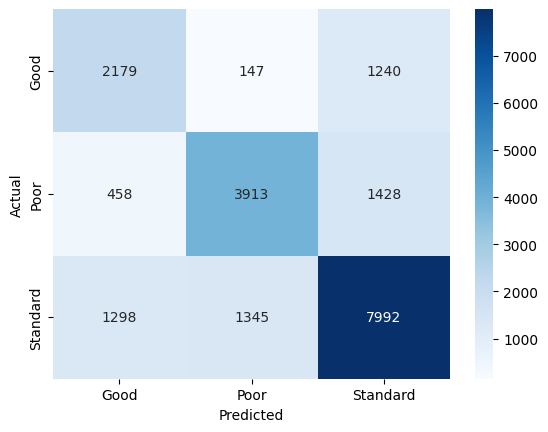

In [26]:
# Confusion matrix heatmap using Seaborn
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

### Hyperparameter Tuning

In [ ]:
# Define the objective functions for Optuna
def knn_objective(trial):
    knn = KNeighborsClassifier(n_neighbors = trial.suggest_int("n_neighbors", 5, 12),
                              weights = trial.suggest_categorical("weights", ["uniform", "distance"]),
                              algorithm = trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
                              leaf_size = trial.suggest_int("leaf_size", 20, 80),
                              p = trial.suggest_int("p", 1, 2))

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(knn, X_train, y_train, cv=cv, scoring=make_scorer(f1_score, average='weighted'))
    return np.mean(score)

sampler = TPESampler(seed=SEED)
study_knn = optuna.create_study(direction='maximize', sampler=sampler)
study_knn.optimize(knn_objective, n_trials=100, n_jobs=-1, timeout=3600, show_progress_bar=True)

[I 2023-04-10 15:42:27,466] A new study created in memory with name: no-name-b429b52e-8bb3-4931-a88f-c3b50f5c1331


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-04-10 15:49:03,546] Trial 0 finished with value: 0.7458187179687219 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 33, 'p': 1}. Best is trial 0 with value: 0.7458187179687219.
[I 2023-04-10 15:55:50,795] Trial 2 finished with value: 0.7442290442604349 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 25, 'p': 1}. Best is trial 0 with value: 0.7458187179687219.
[I 2023-04-10 16:02:18,376] Trial 3 finished with value: 0.742077592216311 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 51, 'p': 1}. Best is trial 0 with value: 0.7458187179687219.
[I 2023-04-10 16:03:29,066] Trial 1 finished with value: 0.6984358130972615 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 77, 'p': 2}. Best is trial 0 with value: 0.7458187179687219.
[I 2023-04-10 16:04:18,589] Trial 5 finished with value: 0.7042300101833612 and

In [ ]:
#best hyperparameters and F1score
print('Best F1 Score = {:.2f}, Best hyperparameters = {}'.format(study_knn.best_value, study_knn.best_params))

Best F1 Score = 0.75, Best hyperparameters = {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 33, 'p': 1}


In [ ]:
# Plot the optimization history and importance of each hyperparameter
optuna.visualization.plot_optimization_history(study_knn).show()
optuna.visualization.plot_param_importances(study_knn).show()

### Training and Predicting with optimal hyperparameters

In [4]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(**{'n_neighbors': 6, 'weights': 'distance', 
                              'algorithm': 'brute', 'leaf_size': 33, 'p': 2})
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
y_pred_knn_train = knn.predict(X_train)

print("\n=== Training Result ===\n") # Overfitting
print(classification_report(y_train, y_pred_knn_train))

print("\n=== Test Result ===\n")
print(classification_report(y_test, y_pred_knn))

conf_matrix = confusion_matrix(y_test, y_pred_knn)
print(conf_matrix)


=== Training Result ===

              precision    recall  f1-score   support

        Good       1.00      1.00      1.00     14262
        Poor       1.00      1.00      1.00     23199
    Standard       1.00      1.00      1.00     42539

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000


=== Test Result ===

              precision    recall  f1-score   support

        Good       0.59      0.57      0.58      3566
        Poor       0.74      0.68      0.71      5799
    Standard       0.74      0.78      0.76     10635

    accuracy                           0.71     20000
   macro avg       0.69      0.68      0.68     20000
weighted avg       0.71      0.71      0.71     20000

[[2042  125 1399]
 [ 313 3958 1528]
 [1094 1255 8286]]


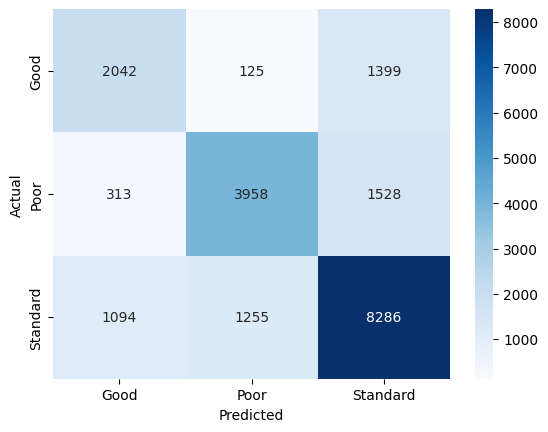

In [5]:
# Confusion matrix heatmap using Seaborn
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

### Permutation Importance

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(**{'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 33, 'p': 1})
knn.fit(X_train, y_train)

f1_scorer = make_scorer(f1_score, average='weighted')

# Calculate permutation importance using the F1 score
result = permutation_importance(knn, X_test, y_test, scoring=f1_scorer, n_repeats=1, random_state=SEED)

# Get the feature importances
feature_importances = result.importances_mean

# Sort and plot the feature importances
indices = np.argsort(feature_importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), indices, rotation="vertical")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

## 5. XGBoost

In [32]:
from xgboost import XGBClassifier

xgboost = XGBClassifier(random_state=SEED)
y_train = y_train.map({'Good':2, 'Standard':1, 'Poor':0})
y_test = y_test.map({'Good':2, 'Standard':1, 'Poor':0})

xgboost.fit(X_train, y_train)

y_pred_xgboost = xgboost.predict(X_test)
y_pred_xgb_train = xgboost.predict(X_train)

print("\n=== Training Result ===\n")
print(classification_report(y_train, y_pred_xgb_train))

print("\n=== Test Result ===\n")
print(classification_report(y_test, y_pred_xgboost))

conf_matrix = confusion_matrix(y_test, y_pred_xgboost)
print(conf_matrix)


=== Training Result ===

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     23199
           1       0.83      0.83      0.83     42539
           2       0.76      0.79      0.77     14262

    accuracy                           0.81     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.81      0.81      0.81     80000


=== Test Result ===

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      5799
           1       0.78      0.79      0.79     10635
           2       0.68      0.71      0.70      3566

    accuracy                           0.76     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.76      0.76      0.76     20000

[[4225 1369  205]
 [1273 8395  967]
 [  49  969 2548]]


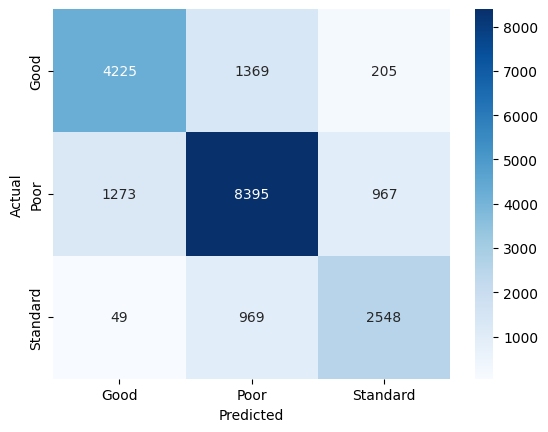

In [33]:
# Confusion matrix heatmap using Seaborn
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [34]:
# Default Hyperparameters
xgboost.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 587,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### Hyperparameter Tuning with Optuna

In [ ]:
# Define the objective functions for Optuna
def xgb_objective(trial):
    xgb = XGBClassifier(n_estimators = trial.suggest_int("n_estimators", 100, 200),
                               max_depth = trial.suggest_int("max_depth", 6, 12),
                               learning_rate = trial.suggest_float("learning_rate", 0.003, 0.6, log=True),
                               subsample = trial.suggest_float("subsample", 0.1, 1),
                               colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1),
                               gamma = trial.suggest_float("gamma", 0, 1))

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(xgb, X_train, y_train, cv=cv, scoring=make_scorer(f1_score, average='weighted'))
    return np.mean(score)

sampler = TPESampler(seed=SEED)
study_xgb = optuna.create_study(direction='maximize', sampler=sampler)
study_xgb.optimize(xgb_objective, n_trials=100, n_jobs=-1, timeout=3600, show_progress_bar=True)

[I 2023-04-10 03:59:32,363] A new study created in memory with name: no-name-87581980-cc8b-473a-a76f-da96e3a25ac9


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-04-10 04:13:29,792] Trial 0 finished with value: 0.7869518492708704 and parameters: {'n_estimators': 129, 'max_depth': 12, 'learning_rate': 0.36737127762238275, 'subsample': 0.6206339574736752, 'colsample_bytree': 0.13788327393025177, 'gamma': 0.4376326340011678}. Best is trial 0 with value: 0.7869518492708704.
[I 2023-04-10 04:21:52,049] Trial 1 finished with value: 0.7420379282534743 and parameters: {'n_estimators': 136, 'max_depth': 7, 'learning_rate': 0.08548148508763107, 'subsample': 0.37085439478305315, 'colsample_bytree': 0.6004638043453232, 'gamma': 0.8154146535609623}. Best is trial 0 with value: 0.7869518492708704.
[I 2023-04-10 04:38:42,070] Trial 2 finished with value: 0.7350712634308929 and parameters: {'n_estimators': 196, 'max_depth': 12, 'learning_rate': 0.012562911067329202, 'subsample': 0.36464629208611954, 'colsample_bytree': 0.1955875459020341, 'gamma': 0.33577520504707914}. Best is trial 0 with value: 0.7869518492708704.
[I 2023-04-10 04:55:43,722] Trial 1 

In [ ]:
#best hyperparameters and F1score
print('Best F1 Score = {:.2f}, Best hyperparameters = {}'.format(study_xgb.best_value, study_xgb.best_params))

Best F1 Score = 0.79, Best hyperparameters = {'n_estimators': 190, 'max_depth': 12, 'learning_rate': 0.04204856678993019, 'subsample': 0.9915831193509314, 'colsample_bytree': 0.3735888073091418, 'gamma': 0.36414738108221145}


In [ ]:
# Plot the optimization history and importance of each hyperparameter
optuna.visualization.plot_optimization_history(study_xgb).show()
optuna.visualization.plot_param_importances(study_xgb).show()

### Training and Predicting with Optimal Hyperparameter

In [54]:
from xgboost import XGBClassifier

y_train = y_train.map({'Good':2, 'Standard':1, 'Poor':0})
y_test = y_test.map({'Good':2, 'Standard':1, 'Poor':0})

xgboost = XGBClassifier(**{'n_estimators': 190, 'max_depth': 11, 'learning_rate': 0.04204856678993019, 
                           'subsample': 0.9915831193509314, 'colsample_bytree': 0.3735888073091418, 
                           'gamma': 0.36414738108221145, 'random_state': SEED})
xgboost.fit(X_train, y_train)

y_pred_xgboost = xgboost.predict(X_test)
y_pred_xgb_train = xgboost.predict(X_train)

print("\n=== Training Result ===\n")
print(classification_report(y_train, y_pred_xgb_train))

print("\n=== Test Result ===\n")
print(classification_report(y_test, y_pred_xgboost))

conf_matrix = confusion_matrix(y_test, y_pred_xgboost)
print(conf_matrix)


=== Training Result ===

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     23199
           1       0.92      0.90      0.91     42539
           2       0.89      0.89      0.89     14262

    accuracy                           0.90     80000
   macro avg       0.90      0.90      0.90     80000
weighted avg       0.90      0.90      0.90     80000


=== Test Result ===

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      5799
           1       0.82      0.81      0.81     10635
           2       0.73      0.75      0.74      3566

    accuracy                           0.79     20000
   macro avg       0.78      0.79      0.78     20000
weighted avg       0.79      0.79      0.79     20000

[[4600 1064  135]
 [1182 8605  848]
 [   7  874 2685]]


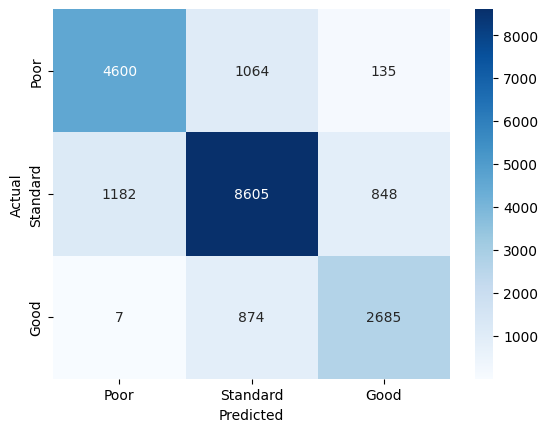

In [56]:
# Confusion matrix heatmap using Seaborn
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Poor', 'Standard', 'Good'], yticklabels=['Poor', 'Standard', 'Good'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [58]:
importances_xgb = xgboost.feature_importances_
importances_xgb

array([0.01019332, 0.00563141, 0.00754619, 0.00758819, 0.01093519,
       0.02324573, 0.02576963, 0.00893393, 0.01423454, 0.00879719,
       0.00787161, 0.01358836, 0.01947563, 0.0038082 , 0.00782455,
       0.00770752, 0.00440486, 0.00592068, 0.00528288, 0.00557628,
       0.00569363, 0.00524044, 0.00531867, 0.00531809, 0.00575732,
       0.00594021, 0.00539623, 0.00562158, 0.00598968, 0.00574076,
       0.00546564, 0.0060031 , 0.00522216, 0.00535521, 0.00545314,
       0.00566743, 0.00535916, 0.0055852 , 0.00551795, 0.00537732,
       0.00572826, 0.03336707, 0.2968212 , 0.12156507, 0.01722897,
       0.00646441, 0.09165197, 0.08124179, 0.00468614, 0.00433258,
       0.0035704 , 0.00343563, 0.00400414, 0.00709129, 0.00345231],
      dtype=float32)

In [ ]:
X_train.columns

Index(['Month', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan',
       'Home Equity Loan', 'Mortgage Loan', 'Not Specified', 'Payday Loan',
       'Personal Loan', 'Student Loan', 'Occupation_Accountant',
       'Occupation_Architect', 'Occupation_Developer', 'Occupation_Doctor',
       'Occupation_Engineer', 'Occupation_Entrepreneur',
       'Occupation_Journalist', 'Occupation_Lawyer', 'Occupation_Manager',
       'Occupation_Mechanic', 'Occupation_Media_Manager',
       'Occupation_Musician', 'Occupation_Scientist', 'Occupation_Teacher',
       'Occupation_Writer', 'Credit_Mix_Bad', 'Credit_Mix_Good',


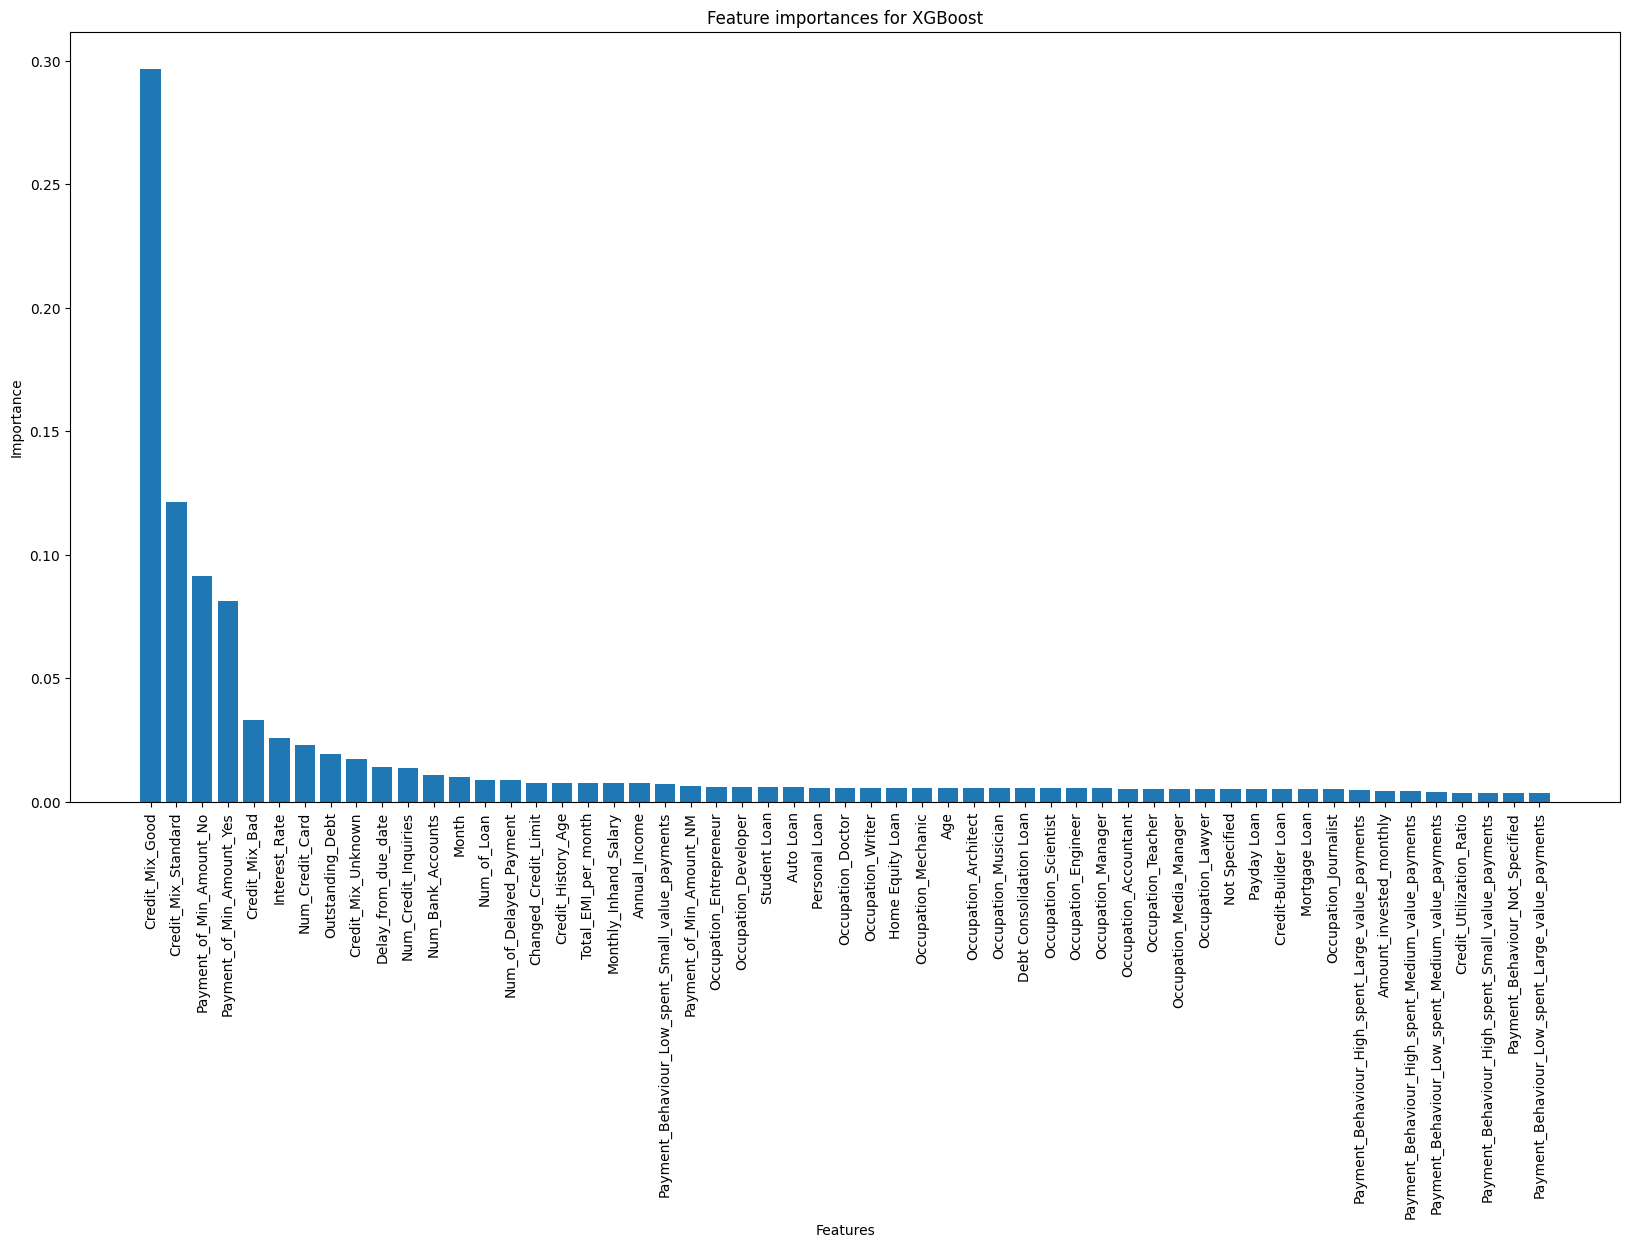

In [59]:
def plot_feature_importances(importances, feature_names, model_name):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(20,10))
    plt.title(f'Feature importances for {model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

plot_feature_importances(importances_xgb, X_train.columns, 'XGBoost')

## 6. Support Vector Machine

In [37]:
from sklearn.svm import SVC

svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
y_pred_svm_train = svm.predict(X_train)

print("\n=== Training Result ===\n")
print(classification_report(y_train, y_pred_svm_train))

print("\n=== Test Result ===\n")
print(classification_report(y_test, y_pred_svm))

conf_matrix = confusion_matrix(y_test, y_pred_svm)
print(conf_matrix)


=== Training Result ===

              precision    recall  f1-score   support

           0       0.79      0.69      0.74     23199
           1       0.78      0.78      0.78     42539
           2       0.59      0.71      0.64     14262

    accuracy                           0.74     80000
   macro avg       0.72      0.73      0.72     80000
weighted avg       0.75      0.74      0.74     80000


=== Test Result ===

              precision    recall  f1-score   support

           0       0.75      0.65      0.70      5799
           1       0.75      0.76      0.76     10635
           2       0.57      0.68      0.62      3566

    accuracy                           0.71     20000
   macro avg       0.69      0.70      0.69     20000
weighted avg       0.72      0.71      0.71     20000

[[3768 1526  505]
 [1218 8057 1360]
 [  36 1089 2441]]


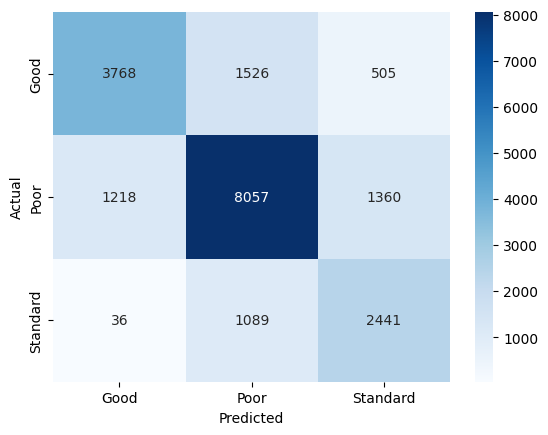

In [38]:
# Confusion matrix heatmap using Seaborn
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

### Hyperparameter Tuning

In [ ]:
# Define the objective functions for Optuna
def svm_objective(trial):
    C = trial.suggest_float("C", 1e-6, 1e+6, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    degree = trial.suggest_int("degree", 2, 5) if kernel == "poly" else None
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"]) if kernel != "linear" else None

    svm = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, class_weight="balanced", random_state=SEED)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(svm, X_train, y_train, cv=cv, scoring=make_scorer(f1_score, average='weighted'))
    return np.mean(score)

sampler = TPESampler(seed=SEED)
study_svm = optuna.create_study(direction='maximize', sampler=sampler)
study_svm.optimize(svm_objective, n_trials=100, n_jobs=-1, timeout=3600, show_progress_bar=True)

In [ ]:
#best hyperparameters and F1score
print('Best F1 Score = {:.2f}, Best hyperparameters = {}'.format(study_svm.best_value, study_svm.best_params))

In [ ]:
# Plot the optimization history and importance of each hyperparameter
optuna.visualization.plot_optimization_history(study_svm).show()
optuna.visualization.plot_param_importances(study_svm).show()

# References

- C. O’Neill and R. Schutt. Doing Data Science., O’Reilly. 2013.
- Grus, Joel. Data Science from Scratch: First Principles with Python. O'Reilly Media, 2015.
- [Dataset](https://www.kaggle.com/datasets/parisrohan/credit-score-classification?select=train.csv)
- [Preprocessed Data](https://buffalo.box.com/s/uq76cc0c0moddpuu8xuw4dvxivupm8l3)
- [Optuna Documentaion](https://optuna.readthedocs.io/en/stable/)
- [Numpy Documentation](https://numpy.org/doc/stable/reference/)
- [Pandas Documentation](https://pandas.pydata.org/docs/reference/)
- [Seaborn Documentation](https://seaborn.pydata.org/api.html)
- [Plotly Documentation](https://plotly.com/python/getting-started/)
- [Matplotlib Documentation](https://matplotlib.org/stable/index.html#matplotlib-release-documentation)
- [Scikit-learn Documentation](https://scikit-learn.org/stable/modules/classes.html)
- [Python Documentation](https://docs.python.org/3.9/library/index.html)